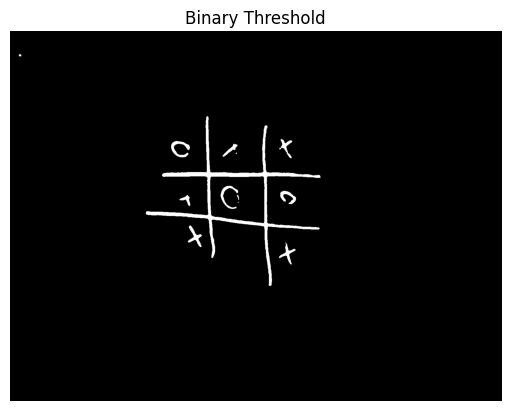

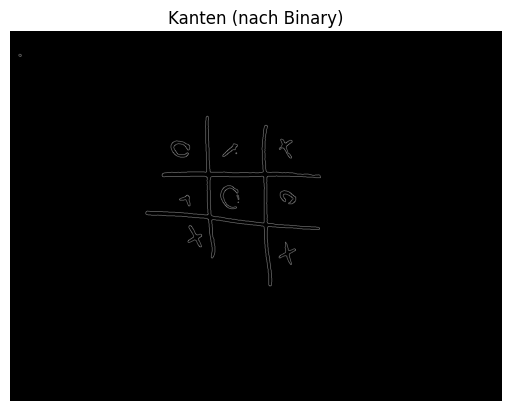

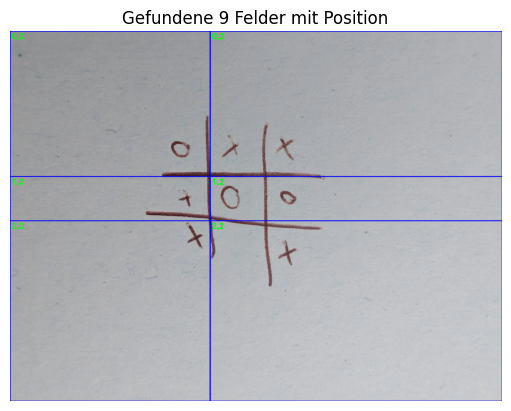

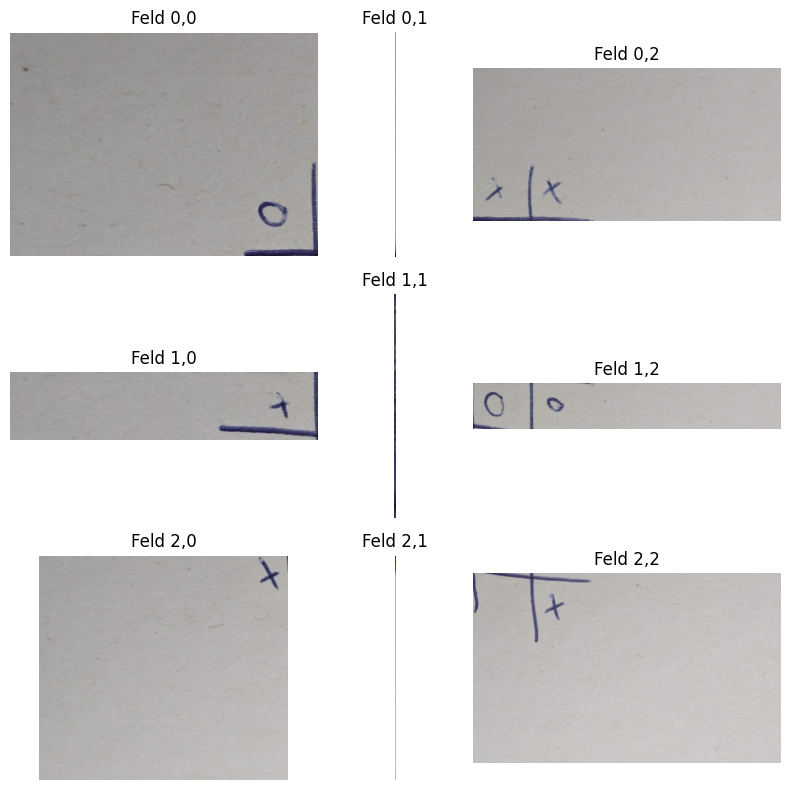

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    """Reduziert eine Liste von Koordinaten auf gruppierte Mittelwerte, um doppelte Linien zu eliminieren."""
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current_cluster = [coords[0]]
    for c in coords[1:]:
        if abs(c - current_cluster[-1]) < mindist:
            current_cluster.append(c)
        else:
            clustered.append(int(np.mean(current_cluster)))
            current_cluster = [c]
    clustered.append(int(np.mean(current_cluster)))
    return clustered

def get_two_most_centered(coords, img_size):
    """Nimmt genau die beiden Linien, die am nächsten zu 1/3 und 2/3 der Bildbreite/-höhe liegen."""
    if len(coords) < 2:
        return None
    targets = [img_size // 3, 2 * img_size // 3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords = [c for c in coords if c != best]
    return sorted(selected)

def detect_tic_tac_toe_grid(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)
    _, binary = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)
    show_image(binary, "Binary Threshold")
    edges = cv2.Canny(binary, 50, 150, apertureSize=3)
    show_image(edges, "Kanten (nach Binary)")

    height, width = gray.shape
    min_dim = min(height, width)
    minLineLength = int(min_dim * 0.15)
    maxLineGap = int(min_dim * 0.2)

    # Linien finden
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=20,
        minLineLength=minLineLength,
        maxLineGap=maxLineGap
    )

    # Linien nach Länge und Richtung sortieren
    verticals = []
    horizontals = []

    if lines is not None:
        # Liste mit (Länge, Linie) für sortieren
        candidate_lines = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dx, dy = x2 - x1, y2 - y1
            length = np.sqrt(dx**2 + dy**2)
            angle = np.degrees(np.arctan2(dy, dx))
            # Vertikal: fast 90 Grad, Horizontal: fast 0 Grad
            if abs(abs(angle) - 90) < 20:
                verticals.append((length, x1, y1, x2, y2))
            elif abs(angle) < 20:
                horizontals.append((length, x1, y1, x2, y2))

        # Nur die 2 längsten Vertikalen & 2 längsten Horizontalen
        verticals = sorted(verticals, reverse=True)[:2]
        horizontals = sorted(horizontals, reverse=True)[:2]

        # Koordinaten der Linien-Mittelpunkte als Schnittstellen nehmen
        clustered_v = sorted([int((x1 + x2) / 2) for _, x1, y1, x2, y2 in verticals])
        clustered_h = sorted([int((y1 + y2) / 2) for _, x1, y1, x2, y2 in horizontals])

    else:
        print("Keine Linien gefunden.")
        return [], []

    # Weiter wie gehabt
    x_coords = [0] + clustered_v + [width]
    y_coords = [0] + clustered_h + [height]

    # Safety
    if len(x_coords) != 4 or len(y_coords) != 4:
        print(f"Fehler: Koordinatenlisten falsch! x: {x_coords}, y: {y_coords}")
        print("Kann Felder nicht sauber extrahieren. Abbruch.")
        return [], []

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    feld_bilder = []
    positionen = []

    for row in range(3):
        for col in range(3):
            x1, x2 = x_coords[col], x_coords[col+1]
            y1, y2 = y_coords[row], y_coords[row+1]
            feld = img[y1:y2, x1:x2]
            feld_bilder.append(feld)
            positionen.append((row, col))
            # Rechteck und Position einzeichnen
            cv2.rectangle(img_grid, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (x1+5, y1+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder mit Position")

    return feld_bilder, positionen


def show_9_fields(feld_bilder, positionen):
    if not feld_bilder or not positionen:
        print("Keine Felder zum Anzeigen!")
        return
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for idx, (feld, pos) in enumerate(zip(feld_bilder, positionen)):
        row, col = pos
        axs[row, col].imshow(cv2.cvtColor(feld, cv2.COLOR_BGR2RGB))
        axs[row, col].set_title(f"Feld {row},{col}")
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Aufruf
feld_bilder, positionen = detect_tic_tac_toe_grid('Filled_Field.png')
show_9_fields(feld_bilder, positionen)
